In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.3.1

# Import thư viện

In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

# Trỏ đường dẫn tới drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab\ Notebooks/UITCARCINGCAR
%ls

# Tạo ra folder chứa các models sẽ lưu

In [ ]:
!mkdir models

# lấy tất cả đường dẫn đến ảnh

In [ ]:
import random
#Lấy tất cả đường đẫn đến ảnh 
filenames=os.listdir("data")
labels=[]
paths=[]
images=[]

for i in filenames:
    path=os.path.join("data/{}".format(i))
    file_images=os.listdir(path)
    for j,f in enumerate(file_images):
        image=os.path.join(path,f)
        images.append(image)
    
#Xáo trộn đường dẫn
random.shuffle(images)


['0', '1', '2']


# Labels


1.   Labels là tên folder chứa các ảnh
2.   Labels ảnh sử dụng phương pháp one-hot encoding



In [ ]:
label = [p.split(os.path.sep)[-2] for p in images]
#Using one hote encoding for the train and validation labels
from keras.utils import to_categorical
label = to_categorical(label, 3)
print(label)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# Đọc ảnh và đưa về kích thước 30x30

In [ ]:
X = []
for (j, imagePath) in enumerate(images):
    image = cv2.imread(imagePath)
    X.append(cv2.resize(image, (30,30)))
X = np.array(X)

# Chia tập dữ liệu 80% traning, 20% validation

In [ ]:
X = X.astype('float32')/255 #đưa giá trị ảnh 0-255 về 0-1
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, label, test_size=0.2, random_state=0)

# Setup callbacks cho quá trình training

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
earlystop = EarlyStopping(patience=15)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = ModelCheckpoint("models/model-{epoch:03d}.h5",
                                 monitor='accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
callbacks = [earlystop,learning_rate_reduction,checkpoint]

# Xây dựng kiến trúc model CNN 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='elu', input_shape=(30, 30, 3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dropout(rate=0.5))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(0.001), 
    metrics=['accuracy']
)
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________

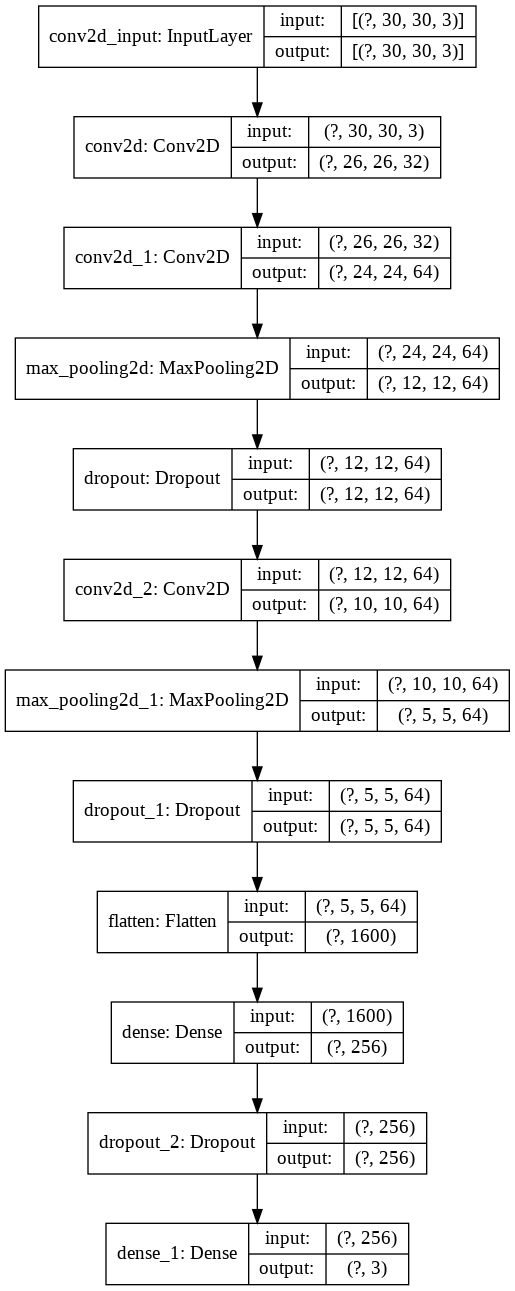

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="my_model.png", show_shapes=True)

# Training

In [ ]:
epochs = 40
history = model.fit(X, label, batch_size=32, epochs=epochs,
validation_data=(X_valid, y_valid),callbacks=callbacks)



##Plot kết quả

In [ ]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

##Kiểm tra thử kết quả

In [ ]:
import os
from keras.models import load_model
model2 = load_model('model-047.h5')

In [ ]:
X_test = cv2.imread('datasetBlue/train/2/1-g1 (356).jpg')
X_test=cv2.resize(X_test,(30, 30))
X_test = X_test.astype('float32')/255 

In [ ]:
X_test = X_test.reshape(1,30,30,3)
predictions = model2.predict(X_test)
print(predictions)

[[5.6057458e-04 2.2494797e-07 9.9902701e-01 4.1214755e-04]]
